# Sperm dataset exploration notebook

Two datasets from two different Western Diet experiments were incorporated. Sperm cells were fixated in ethanol, then stained with PI, and then recorded on Guava Muse. Relevant channels were "RED" - PI flourescence. 

In the next cell, dataset is loaded, extreme outliers within measurements and incongruous replicates were removed, and then dataset's columns were renamed.


In [23]:
#first cell - general data loading, setting relevant_data as global
import pandas as pd
import seaborn as sns
from sklearn.utils import resample 
import pingouin as pg
import numpy as np
import warnings
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

plt.style.use("ggplot")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

data=pd.read_csv("sperm_experiment.csv").iloc[:,1:]
data=data.loc[data["RED-HLin"]<4000]

#ignoring outliers from Replicate frame
data=data.loc[~data.Replicate.isin(["55:2","56:3","57:1","90:1","92:1"])]
data["Sample"]=data["Sample"].astype(str)
#end result is a dataset - we are interested in DNA content
#DNA content is RED-HLing and RED-HLog
global relevant_data
relevant_data = data [["Name","Sample","Replicate","Treatment","Weight/g",
                      "Age at start/days","Exp. duration/days",
                      "RED-HLin","RED-HLog"]].copy()
relevant_data.rename(columns={"Name":"Experiment","RED-HLin":"DNA-Lin","RED-HLog":"DNA-Log"},inplace=True)


def yield_mean_replicate(data,dna_value="DNA-Lin")->pd.DataFrame:
    """Returns DataFrame with Mean DNA value calculated based on Replicate"""
    _l=[]
    for item in set(data.Replicate):
        _subset=data.loc[data.Replicate==item]
        _row=_subset.iloc[0].copy()
        _row=pd.DataFrame(_row).T
        _row.drop(["DNA-Lin","DNA-Log"],axis=1,inplace=True)
        mean=_subset[dna_value].mean()
        _row.insert(0,"Mean DNA",mean)
        _l.append(_row)
    result=pd.concat(_l,ignore_index=True)
    return(result)

def yield_mean_bootstrap(data,n_iter=5,perc=0.4,dna_value="DNA-Lin")->pd.DataFrame:
    """Returns DataFrame with Mean DNA value calculated based on Boostrapping"""
    _l=[]
    for item in set(data.Sample):
        
        _subset=data.loc[data.Sample==item]
        _row=_subset.iloc[0].copy()
        _row=pd.DataFrame(_row).T
        _row.drop(["DNA-Lin","DNA-Log","Replicate"],axis=1,inplace=True)
        
        _series=_subset[dna_value]
        _means=[]
        for i in range(n_iter):
            resampled=resample(_series,replace=False,n_samples=int(perc*len(_series)))
            mean=resampled.mean()
            _means.append(mean)
        #need to repeat _row n_iter times for dimensions to match
        _row=pd.concat([_row]*n_iter, ignore_index=True)
        _row.insert(0,"Mean DNA",_means)
        _l.append(_row)
    result=pd.concat(_l,ignore_index=True)
    return(result)

def yield_mean_replicate_std(data,dna_value="DNA-Lin")->pd.DataFrame:
    """Returns DataFrame with Mean DNA value calculated based on Replicate"""
    _l=[]
    for item in set(data.Replicate):
        _subset=data.loc[data.Replicate==item]
        _row=_subset.iloc[0].copy()
        _row=pd.DataFrame(_row).T
        _row.drop(["DNA-Lin","DNA-Log"],axis=1,inplace=True)
        std=_subset[dna_value].std()
        _row.insert(0,"StDev DNA",std)
        _l.append(_row)
    result=pd.concat(_l,ignore_index=True)
    return(result)

def yield_mean_bootstrap(data,n_iter=5,perc=0.4,dna_value="DNA-Lin")->pd.DataFrame:
    """Returns DataFrame with Mean DNA value calculated based on Boostrapping"""
    _l=[]
    for item in set(data.Sample):
        
        _subset=data.loc[data.Sample==item]
        _row=_subset.iloc[0].copy()
        _row=pd.DataFrame(_row).T
        _row.drop(["DNA-Lin","DNA-Log","Replicate"],axis=1,inplace=True)
        
        _series=_subset[dna_value]
        _stds=[]
        for i in range(n_iter):
            resampled=resample(_series,replace=False,n_samples=int(perc*len(_series)))
            std=resampled.std()
            _stds.append(std)
        #need to repeat _row n_iter times for dimensions to match
        _row=pd.concat([_row]*n_iter, ignore_index=True)
        _row.insert(0,"StDev DNA",_stds)
        _l.append(_row)
    result=pd.concat(_l,ignore_index=True)
    return(result)

In [24]:
#cell for drawing boxplots and pointplots
def _parse(method,dna_value,**kwargs):
    if method == "replicate":
        result = yield_mean_replicate(relevant_data,dna_value)
    elif method == "bootstrap":
        if "n_iter" in kwargs:
            n_iter = kwargs["n_iter"]
        else:
            n_iter = 5
            
        if "perc" in kwargs:
            perc = kwargs["perc"]
        else:
            perc = 0.4
        
        result = yield_mean_bootstrap(relevant_data,n_iter,perc,dna_value)
    else:
        raise ValueError("Chose 'replicate' or 'bootstrap' for method keyword")
    return(result)

def _parse_std(method="replicate",dna_value="DNA-Lin",**kwargs):
    if method == "replicate":
        result = yield_mean_replicate_std(relevant_data,dna_value)
    elif method == "bootstrap":
        if "n_iter" in kwargs:
            n_iter = kwargs["n_iter"]
        else:
            n_iter = 5
            
        if "perc" in kwargs:
            perc = kwargs["perc"]
        else:
            perc = 0.4
        
        result = yield_mean_bootstrap_std(relevant_data,n_iter,perc,dna_value)
    else:
        raise ValueError("Chose 'replicate' or 'bootstrap' for method keyword")
    return(result)
    

def draw_boxplot(x="Sample",method="replicate",dna_value="DNA-Lin", **kwargs):
    """
    Function for drawing boxplot
    ___
    
    Arguments:
    ___
    data = pandas DataFrame
    x = column in pandasDataFrame
    method = "bootstrap" or "replicate"
    dna_value = column in pandasDataFrame, what value is to be used as a dna_value proxy
        "DNA-Lin" and "DNA-Log" are acceptable choices
    ___
    
    Additional arguments
    ___
    hue = coloring boxplot based on this column in data, by default is "Treatment" unless x is "Treatment"
    n_iter = number of iterations for bootstrap method
    perc = percent of sample size to be resampled for bootstrap method
    ___
    """
    #PARSE DATA
    if "data" in kwargs:
        result = kwargs["data"]
    else:
        result = _parse(method,dna_value,**kwargs)
    
    #PARSE HUE
    hue = None
    if "hue" in kwargs:
        hue = kwargs["hue"]
    
    #PARSE X
    if x=="Sample":
        my_order = [58,60,92,91,90,55,56,57,87,88,89]
        my_order = [str(item) for item in my_order]
        if hue is None:
            hue="Treatment"
    elif x=="Treatment":
        my_order =["C","WD"]
    elif x=="Experiment":
        my_order = ["WD1","WD2"]
        if hue is None:
            hue="Treatment"
    else :
        my_order = None
        if hue is None:
            hue = "Treatment"
            
    if "data" not in kwargs:
        ax=sns.boxplot(data=result,x=x,y="Mean DNA",hue=hue,order=my_order)
        ax.set_title("Boxplot of Mean DNA content")
    else:
        ax=sns.boxplot(data=result,x=x,y="StDev DNA",hue=hue,order=my_order)
        ax.set_title("Boxplot of StDev DNA content")
    
    bottom = None
    top = None
    
    if "y_upper" in kwargs:
        y_upper = kwargs["y_upper"]
        if y_upper != 0:
             top = y_upper
    
    if "y_lower" in kwargs:
        y_lower = kwargs["y_lower"]
        if y_lower != 0:
             bottom = y_lower
    
    ax.set_ylim(bottom=bottom,top=top)
    
    if "y_lim" in kwargs:
        if isinstance(kwargs["y_lim"],tuple):
            ax.set_ylim(kwargs["y_lim"])
            
            
def draw_pointplot(method="replicate",x="Experiment",hue="Treatment",dna_value = "DNA-Lin",**kwargs):
    if "data" in kwargs:
        result = kwargs["data"]
    else:
        result = _parse(method,dna_value,**kwargs)
    
    if "data" in kwargs:
        ax=sns.pointplot(data = result, x = "Experiment", y = "StDev DNA", hue = hue,
                 dodge = True,capsize = 0.1)
    else:
        ax=sns.pointplot(data = result, x = "Experiment", y = "Mean DNA", hue = hue,
                 dodge = True,capsize = 0.1)

    
    if "y_lim" in kwargs:
        if isinstance(kwargs["y_lim"],tuple):
            ax.set_ylim(kwargs["y_lim"])

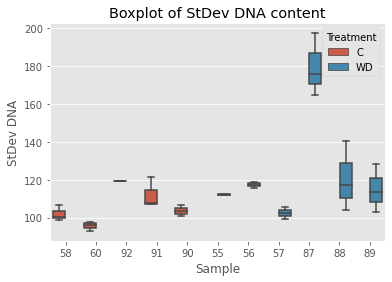

In [34]:
std_data=_parse_std()
#
draw_boxplot(data=std_data)

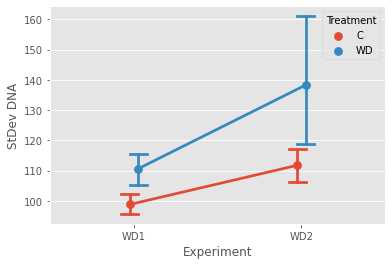

In [26]:
draw_pointplot(data=std_data)

In [27]:
#cell for doing simple T_test
def t_test(between="Treatment", param="parametric", method="replicate",dna_value="DNA-Lin",**kwargs):
    """
    Function for doing t_test
    ___
    
    Arguments:
    ___
    data = pandas DataFrame
    between = between what is being tested - must have a length of 2 (eg. "Treatment" or "Experiment")
    method = "bootstrap" or "replicate"
    param = "parametric" or "non-parametric"
        parametric means t-test, non-parametric means Mann Whitney
    dna_value = column in pandasDataFrame, or what is the dependent variable
        "DNA-Lin" and "DNA-Log" are acceptable choices
    ___
    
    Additional arguments
    ___
    
    n_iter = number of iterations for bootstrap method
    perc = percent of sample size to be resampled for bootstrap method
    ___
    """
    #PARSE DATA
    if "data" not in kwargs:
        result = _parse(method,dna_value,**kwargs)
    else:
        result=kwargs["data"]
    
    #parse between
    iterator=sorted(list(set(result[between])))
    if len(iterator)!=2:
        raise ValueError("More than two values for between")
    if "data" not in kwargs:
        first=result.loc[result[between]==iterator[0]]["Mean DNA"]
        second=result.loc[result[between]==iterator[1]]["Mean DNA"]
    else:
        first=result.loc[result[between]==iterator[0]]["StDev DNA"]
        second=result.loc[result[between]==iterator[1]]["StDev DNA"]
    
    #parse param
    if param=="parametric":
        test=pg.ttest(x=first,y=second)

    elif param=="non-parametric":
        test=pg.mwu(x=first,y=second)
    else:
        print("Not valid option, defaulting to parametric")
        test=pg.ttest(x=first,y=second)
    return(test)

# Plots

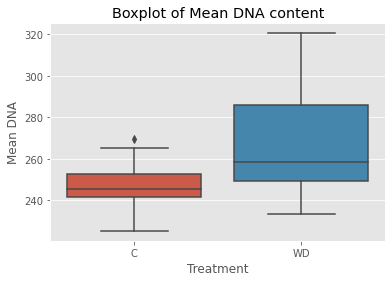

In [28]:
draw_boxplot(dna_value="DNA-Lin",method="replicate",x="Treatment")

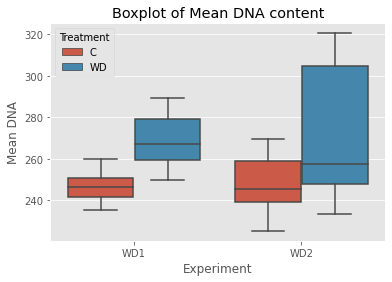

In [29]:
draw_boxplot(dna_value="DNA-Lin",method="replicate",x="Experiment",hue="Treatment")

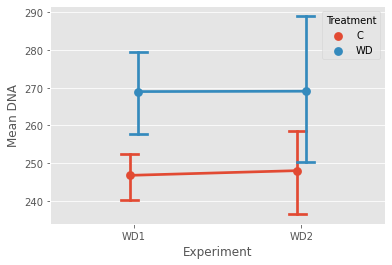

In [30]:
draw_pointplot(dna_value="DNA-Lin", method="replicate",x="Experiment",hue="Treatment")

# Series of parametric/non-parametric t-tests for MEAN DNA
 

In [31]:
a=t_test(between="Treatment",param="parametric",method="replicate",dna_value="DNA-Lin")
b=t_test(between="Experiment",param="parametric",method="replicate",dna_value="DNA-Lin")
a.insert(0,"Based on","Treatment")
b.insert(0,"Based on","Experiment")
ab=pd.concat([a,b],ignore_index=True)

display(ab)

a=t_test(between="Treatment",param="non-parametric",method="replicate",dna_value="DNA-Lin")
b=t_test(between="Experiment",param="non-parametric",method="replicate",dna_value="DNA-Lin")
a.insert(0,"Based on","Treatment")
b.insert(0,"Based on","Experiment")
ab=pd.concat([a,b],ignore_index=True)

display(ab)


data=_parse("replicate","DNA-Lin")

data["Qualifier"]=data["Experiment"]+"-"+data["Treatment"]

posthoc=pg.pairwise_ttests(data=data,dv="Mean DNA",between="Qualifier",
                           parametric=False,padjust="sidak")
display(posthoc)

,Based on,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
0,Treatment,-2.886741,20.837127,two-sided,0.008871,"[-37.19, -6.03]",1.044815,6.196,0.756244
1,Experiment,-0.237903,24.947890,two-sided,0.813899,"[-19.21, 15.23]",0.084670,0.363,0.055245


,Based on,U-val,tail,p-val,RBC,CLES
0,Treatment,48.0,two-sided,0.023995,0.507692,0.246154
1,Experiment,103.0,two-sided,0.762839,-0.072917,0.536458


,Contrast,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
0,Qualifier,WD1-C,WD2-C,False,False,18.0,two-sided,0.720985,0.999528,sidak,-0.089463
1,Qualifier,WD1-C,WD1-WD,False,False,4.0,two-sided,0.030639,0.170315,sidak,-1.683534
2,Qualifier,WD1-C,WD2-WD,False,False,17.0,two-sided,0.262890,0.839604,sidak,-0.819807
3,Qualifier,WD2-C,WD1-WD,False,False,7.0,two-sided,0.053784,0.282302,sidak,-1.273916
4,Qualifier,WD2-C,WD2-WD,False,False,20.0,two-sided,0.244277,0.813715,sidak,-0.759469
5,Qualifier,WD1-WD,WD2-WD,False,False,33.0,two-sided,0.516868,0.987283,sidak,-0.003297


# Series of parametric/non-parametric t-tests for StDEV DNA

In [10]:
a=t_test(data=std_data,between="Treatment",param="parametric",method="replicate",dna_value="DNA-Lin")
b=t_test(data=std_data,between="Experiment",param="parametric",method="replicate",dna_value="DNA-Lin")
a.insert(0,"Based on","Treatment")
b.insert(0,"Based on","Experiment")
ab=pd.concat([a,b],ignore_index=True)
display(ab)

a=t_test(data=std_data,between="Treatment",param="non-parametric",method="replicate",dna_value="DNA-Lin")
b=t_test(data=std_data,between="Experiment",param="non-parametric",method="replicate",dna_value="DNA-Lin")
a.insert(0,"Based on","Treatment")
b.insert(0,"Based on","Experiment")
ab=pd.concat([a,b],ignore_index=True)
display(ab)

std_data["Qualifier"]=std_data["Experiment"]+"-"+std_data["Treatment"]
posthoc=pg.pairwise_ttests(data=std_data,dv="StDev DNA",between="Qualifier",
                           parametric=False,padjust="fdr_by")
#rows 1 and 4

display(posthoc)

,Based on,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
0,Treatment,-2.472559,19.846453,two-sided,0.022589,"[-35.26, -2.98]",0.867296,3.09,0.645347
1,Experiment,-2.762719,24.433206,two-sided,0.010723,"[-34.37, -4.99]",0.895743,5.131,0.662373


,Based on,U-val,tail,p-val,RBC,CLES
0,Treatment,68.0,two-sided,0.041779,0.433333,0.283333
1,Experiment,48.0,two-sided,0.006103,0.589744,0.205128


,Contrast,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
0,Qualifier,WD1-C,WD2-C,False,False,2.0,two-sided,0.003885,0.028555,fdr_by,-1.886612
1,Qualifier,WD1-C,WD1-WD,False,False,3.0,two-sided,0.012419,0.060855,fdr_by,-1.612270
2,Qualifier,WD1-C,WD2-WD,False,False,2.0,two-sided,0.003885,0.028555,fdr_by,-1.387018
3,Qualifier,WD2-C,WD1-WD,False,False,37.0,two-sided,0.596628,1.000000,fdr_by,0.095556
4,Qualifier,WD2-C,WD2-WD,False,False,26.0,two-sided,0.216373,0.636137,fdr_by,-0.887139
5,Qualifier,WD1-WD,WD2-WD,False,False,18.0,two-sided,0.168801,0.620345,fdr_by,-0.861010


# Playing section, with widgets


In [32]:
#WIDGET DRAWING
###DEFINING OPTIONS
acceptable_columns = ['Experiment', 'Sample', 'Replicate', 'Treatment', 'Weight/g',
       'Age at start/days', 'Exp. duration/days',]
x_options = [(item,item) for item in acceptable_columns]
hue_options = x_options.copy()
hue_options.insert(0,("None",None))

between_simple_options =[]
for col in acceptable_columns:
    if len(set(relevant_data[col]))==2:
        between_simple_options.append(col)

###DEFINING WIDGETS
paramW = widgets.Dropdown(options = [("Parametric","parametric"),("Non-Parametric","non-parametric")],
                         value="parametric",
                         description = "Type")
between_simpleW = widgets.Dropdown(options = between_simple_options,
                           value = "Treatment",
                           description = "Between")

methodW = widgets.Dropdown(options = [('Replicate',"replicate"),("Bootstrap","bootstrap")],
                        value = "replicate",
                         description = "Method",
                        )
dna_valueW = widgets.Dropdown(options = [('Linear',"DNA-Lin"),("Log","DNA-Log")],
                        value = "DNA-Lin",
                         description = "DNA value",
                        )
xW = widgets.Dropdown(options = x_options,
                     value = "Sample",
                     description = "X",
                      )
hueW = widgets.Dropdown(options = hue_options,
                         value = None,
                         description = "Hue")
n_iterW = widgets.IntSlider(value=5,
                           min=3,
                           max=15,
                           step=1,
                           description="Iterations")
perc_sampleW = widgets.FloatSlider(value=0.4,
                                min=0.3,
                                max=0.9,
                                step=0.1,
                                description = "Sample")
y_lowerW = widgets.FloatText(value = None,
                            description = "Y lower")

y_upperW = widgets.FloatText(value=None,
                           description = "Y upper")


In [33]:
widgets.interactive(draw_boxplot,method=methodW,dna_value=dna_valueW,x=xW,hue=hueW,n_iter=n_iterW,perc_sample=perc_sampleW,
                    y_upper=y_upperW, y_lower = y_lowerW)



interactive(children=(Dropdown(description='X', index=1, options=(('Experiment', 'Experiment'), ('Sample', 'Sa…

In [13]:
def draw_violinplot(x="Sample",method="replicate",dna_value="DNA-Lin", **kwargs):
    """
    Function for drawing boxplot
    ___
    
    Arguments:
    ___
    data = pandas DataFrame
    x = column in pandasDataFrame
    method = "bootstrap" or "replicate"
    dna_value = column in pandasDataFrame, what value is to be used as a dna_value proxy
        "DNA-Lin" and "DNA-Log" are acceptable choices
    ___
    
    Additional arguments
    ___
    hue = coloring boxplot based on this column in data, by default is "Treatment" unless x is "Treatment"
    n_iter = number of iterations for bootstrap method
    perc = percent of sample size to be resampled for bootstrap method
    ___
    """
    #PARSE DATA
    
    print(relevant_data.columns)
    #PARSE HUE
    hue = None
    if "hue" in kwargs:
        hue = kwargs["hue"]
    

    #PARSE X
    if x=="Sample":
        my_order = [58,60,92,91,90,55,56,57,87,88,89]
        my_order = [str(item) for item in my_order]
        if hue is None:
            hue="Treatment"
    elif x=="Treatment":
        my_order =["C","WD"]
    elif x=="Experiment":
        my_order = ["WD1","WD2"]
        if hue is None:
            hue="Treatment"
    else :
        my_order = None
        if hue is None:
            hue = "Treatment"
            
    ax=sns.violinplot(data=relevant_data,x=x,y=dna_value,hue=hue,order=my_order,cut=0)
    ax.set_title("Boxplot of Mean DNA content")
    
    bottom = None
    top = None
    
    if "y_upper" in kwargs:
        y_upper = kwargs["y_upper"]
        if y_upper != 0:
             top = y_upper
    
    if "y_lower" in kwargs:
        y_lower = kwargs["y_lower"]
        if y_lower != 0:
             bottom = y_lower
    
    ax.set_ylim(bottom=bottom,top=top)
    
    if "y_lim" in kwargs:
        if isinstance(kwargs["y_lim"],tuple):
            ax.set_ylim(kwargs["y_lim"])
widgets.interactive(draw_violinplot,method=methodW,dna_value=dna_valueW,x=xW,hue=hueW,n_iter=n_iterW,perc_sample=perc_sampleW,
                    y_upper=y_upperW, y_lower = y_lowerW)


interactive(children=(Dropdown(description='X', index=1, options=(('Experiment', 'Experiment'), ('Sample', 'Sa…